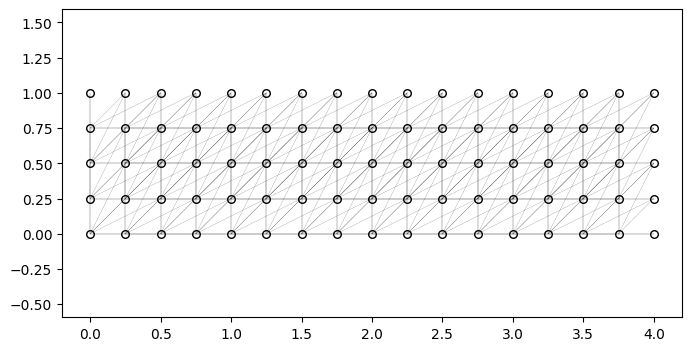

TypeError: 'Variable' object does not support item assignment

In [3]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

L = 4
w = 1

dx = 0.25
dy = dx

x = np.arange(0, L + dx, dx)
y = np.arange(0, 1 + dy, dy)
X, Y = np.meshgrid(x, y)
Nodes = np.column_stack((X.flatten(), Y.flatten()))
n = Nodes.shape[0]

r = np.sqrt(dx**2 + dy**2) * 1.1
D = np.linalg.norm(Nodes[:, None, :] - Nodes[None, :, :], axis=-1)
Idx = [np.where(d <= r)[0] for d in D]

m = 0
CC = []
for i in range(len(Idx)):
    m += len(Idx[i]) - 1
    for j in range(1, len(Idx[i])):
        cc = np.zeros(n)
        cc[Idx[i][0]] = 1
        cc[Idx[i][j]] = -1
        CC.append(cc)

CC = np.array(CC)
ia = np.unique(np.abs(CC), axis=0, return_index=True)[1]
C = CC[ia]

m = C.shape[0]

def plot_structure(Nodes, C, sig, lw):
    for i in range(C.shape[0]):
        if np.abs(sig[i]) > 1e-6:
            if sig[i] > 0:
                c = 'r'
            else:
                c = 'k'
            ii = np.where(np.abs(C[i, :]) == 1)[0]
            NN = Nodes[ii, :].T
            plt.plot(NN[0], NN[1], c, linewidth=lw)
    plt.scatter(Nodes[:, 0], Nodes[:, 1], 30, marker='o', edgecolors='k', facecolors='w', linewidth=1)
    plt.axis('equal')
    plt.show()

fig = plt.figure(figsize=(8, 4))

plot_structure(Nodes, C, -np.ones(m), 0.1)

iReactionNodes = np.where(Nodes[:, 0] == 0)[0]
iLoadNode = 16 * 5 + 3

Fext = np.zeros((2, n))
Fext[1, iLoadNode] = -1

w = np.ones(m)
for i in range(3):
    sig = cp.Variable(m)
    r = cp.Variable((2, len(iReactionNodes)))

    R = cp.Variable((2, n))
    R[:, iReactionNodes] = r

    objective = cp.Minimize(cp.norm(w * sig, 1))
    constraints = [Nodes.T @ C.T @ cp.diag(sig) @ C == Fext + R]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK)

    w = 1 / (np.abs(sig.value.flatten()) + np.finfo(float).eps)

def plot_structure(Nodes, C, sig, lw):
    for i in range(C.shape[0]):
        if np.abs(sig[i]) > 1e-6:
            if sig[i] > 0:
                c = 'r'
            else:
                c = 'k'
            ii = np.where(np.abs(C[i, :]) == 1)[0]
            NN = Nodes[ii, :].T
            plt.plot(NN[0], NN[1], c, linewidth=lw)
    plt.scatter(Nodes[:, 0], Nodes[:, 1], 30, marker='o', edgecolors='k', facecolors='w', linewidth=1)
    plt.axis('equal')
    plt.show()

fig = plt.figure(figsize=(8, 4))

plot_structure(Nodes, C, sig.value.flatten(), 2)
plt.savefig('optimized_structure.eps', format='eps')

